In [23]:
import itertools
from jax.lax.lax import sqrt
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('.')

import glns

In [24]:
X_DIM = 4
A, B = 1, 1.


In [25]:
def radial_sine(x):
    """y = A * cos(sqrt(x0^2 + x1^4)) + B * sin(x2 + x3^2)
    Requires final size of x to be 4
    """
    assert x.shape[-1] == 4, x.shape
    raw_radial_sin = (
        A * np.cos(np.sqrt(x[..., 0] ** 2 + x[..., 1] ** 4)*0.5)
        + B * np.sin((x[..., 2] + x[..., 3] ** 2)*0.))
    positive_radial_sin = raw_radial_sin + (A + B)
    normed_radial_sin = positive_radial_sin / (2 * (A + B))
    assert np.all(normed_radial_sin >= 0.) and np.all(normed_radial_sin <= 1.)
    return normed_radial_sin

# def radial_sine(x):
#     """y = A * cos(sqrt(x0^2 + x1^4)) + B * sin(x2 + x3^2)
#     Requires final size of x to be 4
#     """
#     assert x.shape[-1] == 4, x.shape
#     raw_radial_sin = (
#         A * np.cos(np.sqrt(x[..., 0] ** 2 + x[..., 1] ** 2))
#         + B * np.sin(np.sqrt(x[..., 2]**2 + x[..., 3]**2)))
#     positive_radial_sin = raw_radial_sin + (A + B)
#     normed_radial_sin = positive_radial_sin / (2 * (A + B))
#     assert np.all(normed_radial_sin >= 0.) and np.all(normed_radial_sin <= 1.)
#     return normed_radial_sin

def input_mean_transform(x):
    ''' Changes the range of x from  [-4.8, -5, -0.418, -2] to [4.8, 5, 0.418, 2]
    to each being in [0, 1]
    '''
    x = x / np.array([4.8, 5, 0.418, 2])

    # x = x / np.array([1,1])

    x = (x + 1) / 2

    return x

def sideinfo_transform(x):
    ''' Changes the range of x from  [-4.8, -5, -0.418, -2] to [4.8, 5, 0.418, 2]
    to each being in [-1, 1]
    '''
    x = x / np.array([4.8, 5, 0.418, 2])

    return x

def make_data(n):
    """Make X Data of shape (N_DATA, X_DIM)
    x_data in range [-4.8, -5, -0.418, -2] to [4.8, 5, 0.418, 2]
    y_data in range [0, 1]
    """
    x_all = (np.random.rand(n, X_DIM)*2 - 1) * np.array([4.8, 5, 0.418, 2])
    # x_all = np.random.rand(n, X_DIM) * 2 - 1
    x_all[:,2]=0
    x_all[:,3]=0
    y_all = radial_sine(x_all)

    # x_all = input_mean_transform(x_all)

    return x_all, y_all


def abs_error(y_lab, y_pred):
    return np.mean(np.abs(y_lab - y_pred))


def make_gln(size, bs, lr, bias_std=None, min_sigma_sq=0.1):
    layers, context = size
    return glns.GGLN(
        layer_sizes=layers,
        input_size=X_DIM,
        context_dim=4,
        lr=lr,
        min_sigma_sq=min_sigma_sq,
        bias_len=3,
        batch_size=bs,
        init_bias_weights=[None, None, None],
        input_mean_transform=input_mean_transform,
        sideinfo_transform=sideinfo_transform,
        bias_std=bias_std)



In [26]:
make_data(3)

(array([[ 2.16041533,  1.89301028,  0.        ,  0.        ],
        [-2.70743174, -0.53198365,  0.        ,  0.        ],
        [-0.11167982,  4.49152945,  0.        ,  0.        ]]),
 array([0.37548104, 0.55204282, 0.30285424]))

In [27]:
bb = ([1,2,3], 3, 4, [0,9,1])
c = np.meshgrid(*bb)

In [28]:
c

[array([[[[1, 1, 1]],
 
         [[2, 2, 2]],
 
         [[3, 3, 3]]]]),
 array([[[[3, 3, 3]],
 
         [[3, 3, 3]],
 
         [[3, 3, 3]]]]),
 array([[[[4, 4, 4]],
 
         [[4, 4, 4]],
 
         [[4, 4, 4]]]]),
 array([[[[0, 9, 1]],
 
         [[0, 9, 1]],
 
         [[0, 9, 1]]]])]

In [29]:

def learn_sin(
        gln_size, n_train, n_val, n_test, batch_size, lr, bias_std, min_sigma_sq,silent=False):
    x_train, y_train = make_data(n=n_train)
    x_val, y_val = make_data(n=n_val)
    gln = make_gln(gln_size, batch_size, lr, bias_std=bias_std, min_sigma_sq=min_sigma_sq)

    # TRAIN

    val_losses_save = []

    n_steps = n_train // batch_size
    for i in range(0, n_train, batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        gln.predict(x_batch, target=y_batch)
        if (i % (n_steps // 10)) == 0:
            val_losses = []
            for j in range(0, n_val, batch_size):
                val_preds = gln.predict(x_val[j:j+batch_size])
                val_losses.append(abs_error(y_val[j:j+batch_size], val_preds))
            if not silent:
                print(f"BATCH {i // batch_size} / {n_train // batch_size} - "
                      f"val loss", np.mean(val_losses))
            val_losses_save.append(np.mean(val_losses))

    # TEST
    x_test, y_test = make_data(n=n_test)
    final_losses = []
    for i in range(0, n_test, batch_size):
        y_test_preds = gln.predict(x_test[i:i+batch_size])
        final_losses.append(abs_error(y_test[i:i+batch_size], y_test_preds))
    final_loss = np.mean(final_losses)
    print("TEST LOSS", final_loss)

    x1_plot = np.linspace(-1, 1, 100)* [4.8, 5, 0.418, 2][0]
    x2_plot = np.linspace(-1, 1, 100)* [4.8, 5, 0.418, 2][1]

    pred_vals, true_vals = gln_grid((x1_plot, x2_plot, 0, 0), gln, batch_size)
    fig = plt.figure()
    
    fig.add_subplot(1,2,1)
    plt.pcolor(x1_plot, x2_plot, pred_vals)
    plt.colorbar()

    
    fig.add_subplot(1,2,2)
    plt.pcolor(x1_plot, x2_plot, true_vals)
    plt.colorbar()

    return val_losses_save, final_loss, gln


def gln_grid(x, gln, batch_size):
    
    lens = []
    for xi in x:
        if isinstance(xi, (list, np.ndarray)):
            if len(xi)>1:
                lens.append(len(xi))

    x_mesh= np.meshgrid(*x)
    x_long = np.stack([xm.flatten().T for xm in x_mesh]).T
    pred_vals = np.zeros(len(x_long))
    true_vals = np.zeros(len(x_long))

    for i in range(0, len(x_long), batch_size):
        x_batch = x_long[i:i+batch_size]
        pred_vals[i: i+batch_size] = gln.predict(x_batch)
        true_vals[i: i+batch_size] = radial_sine(x_batch)
    return pred_vals.reshape(lens[0], lens[1]), true_vals.reshape(lens[0], lens[1])

In [30]:
[3,4,4,3,0][3]

3

Running (([64, 128, 64, 32, 1], 4), 8000, 1000, 1000, 32, 0.5, 2, 0.5)
BATCH 0 / 250 - val loss 0.1515828
BATCH 25 / 250 - val loss 0.14707911
BATCH 50 / 250 - val loss 0.1427413
BATCH 75 / 250 - val loss 0.13850111
BATCH 100 / 250 - val loss 0.13711739
BATCH 125 / 250 - val loss 0.13631685
BATCH 150 / 250 - val loss 0.13542905
BATCH 175 / 250 - val loss 0.130404
BATCH 200 / 250 - val loss 0.13066414
BATCH 225 / 250 - val loss 0.12873362
TEST LOSS 0.121355966


<ipython-input-29-505f5bfb8099>:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x1_plot, x2_plot, pred_vals)
<ipython-input-29-505f5bfb8099>:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x1_plot, x2_plot, true_vals)


Running (([64, 128, 64, 32, 1], 4), 8000, 1000, 1000, 32, 0.5, 1, 0.5)
BATCH 0 / 250 - val loss 0.15398395
BATCH 25 / 250 - val loss 0.14779648
BATCH 50 / 250 - val loss 0.14531735
BATCH 75 / 250 - val loss 0.14021504
BATCH 100 / 250 - val loss 0.13761562
BATCH 125 / 250 - val loss 0.13413867
BATCH 150 / 250 - val loss 0.13146569
BATCH 175 / 250 - val loss 0.12807779
BATCH 200 / 250 - val loss 0.12324608
BATCH 225 / 250 - val loss 0.11969827
TEST LOSS 0.11458114
Running (([64, 128, 64, 32, 1], 4), 8000, 1000, 1000, 32, 0.5, 0.5, 0.5)
BATCH 0 / 250 - val loss 0.1514189
BATCH 25 / 250 - val loss 0.14058149
BATCH 50 / 250 - val loss 0.13535398
BATCH 75 / 250 - val loss 0.12899646
BATCH 100 / 250 - val loss 0.12478794
BATCH 125 / 250 - val loss 0.12145444
BATCH 150 / 250 - val loss 0.118853316
BATCH 175 / 250 - val loss 0.11559296
BATCH 200 / 250 - val loss 0.112829834
BATCH 225 / 250 - val loss 0.10971315
TEST LOSS 0.10510853


<Figure size 432x288 with 0 Axes>

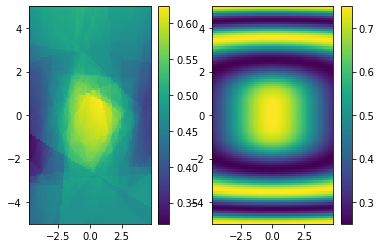

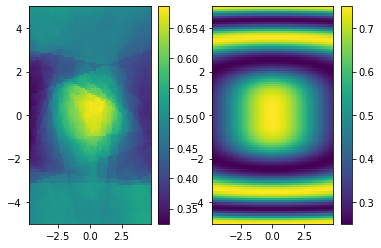

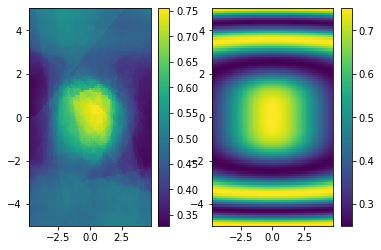

In [33]:
GLN_SIZES = [([256,256,128, 64, 32, 1], 4)]  # Fairly optimal
GLN_SIZES = [([64,128, 64, 32, 1], 4)]  # Fairly optimal
# GLN_SIZES = [([256,1024,256, 64, 32, 1], 4)]  # Fairly optimal

N_TRAIN_DATAS = [8000]
N_VAL_DATAS = [1000]
N_TEST_DATAS = [1000]
BATCH_SIZES = [32]  # Fairly optimal
LR = [5e-1]  # Fairly optimal
BIAS_STDS = [1e9, 1000,10, 1., 0.5, 0.1, 0.05, 0.01]
MIN_SIGMA_SQ = [1., 0.5, 0.1, 0.05, 0.01]
# BIAS_STDS = [100, 1., 0.05, 0.0001]
# BIAS_STDS = [100, 0.0001]
BIAS_STDS = [100, 10, 1., 0.5, 0.1, 0.05, 0.001, 0.0001]
MIN_SIGMA_SQ = [0.5]
# MIN_SIGMA_SQ = [1.,0.5, 0.1, 0.05, 0.01, 0.001]
BIAS_STDS = [2,1,0.5]
# BIAS_STDS = [1]

# MIN_SIGMA_SQ = [1,0.5,0.1]
# BIAS_STDS = [1e9, 0.05]

iterate_through = [
    GLN_SIZES, N_TRAIN_DATAS, N_VAL_DATAS, N_TEST_DATAS, BATCH_SIZES, LR, BIAS_STDS, MIN_SIGMA_SQ
]

fig = plt.figure()

plt_num = 1
final_losses =[]
gln_list = []
for combination in itertools.product(*iterate_through):
    print("Running", combination)
    val_losses, final_loss, gln = learn_sin(*combination, silent=False)
    final_losses.append(final_loss)
    gln_list.append(gln)
#     fig.add_subplot(len(BIAS_STDS), len(MIN_SIGMA_SQ), plt_num)
#     plt.plot(val_losses)
#     plt.title(f'bias_std: {combination[-2]}, min_sigma_sq: {combination[-1]}')
#     plt_num += 1 

<ipython-input-35-c86eaf05499d>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x1_plot, x2_plot, pred_vals)
<ipython-input-35-c86eaf05499d>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x1_plot, x2_plot, true_vals)


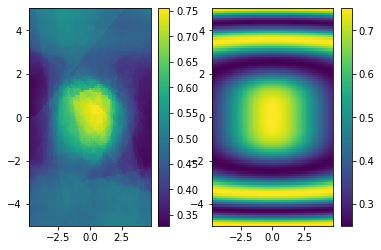

In [35]:
gln = gln_list[2]
x1_plot = np.linspace(-1, 1, 100)* [4.8, 5, 0.418, 2][0]
x2_plot = np.linspace(-1, 1, 100)* [4.8, 5, 0.418, 2][1]

pred_vals, true_vals = gln_grid((x1_plot, x2_plot,0,0), gln, 32)
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.pcolor(x1_plot, x2_plot, pred_vals)
plt.colorbar()


fig.add_subplot(1,2,2)
plt.pcolor(x1_plot, x2_plot, true_vals)
plt.colorbar()

1+1

In [25]:
radial_sine(np.random.randn(9,))

array([0.29595295, 0.65966613, 0.21274761, 0.05007051, 0.94690918,
       0.55516016, 0.66751764, 0.01951454, 0.92504705])